# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository:

Link to nbviewer render:

#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [1]:
# STARTER CODE
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls



Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/esm.git to /private/var/folders/kp/6b76ck697ll0tr5hnddcwfnm0000gp/T/pip-req-build-np1yfl5k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /private/var/folders/kp/6b76ck697ll0tr5hnddcwfnm0000gp/T/pip-req-build-np1yfl5k
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  8787k 

In [2]:
FASTA_PATH = "/Users/hy2897/Desktop/Columbia DBMI/25Spring/Machine Learning for Healthcare/Assigment/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "/Users/hy2897/Desktop/Columbia DBMI/25Spring/Machine Learning for Healthcare/Assigment/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

In [3]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)

/var/folders/kp/6b76ck697ll0tr5hnddcwfnm0000gp/T/ipykernel_91571/1060336957.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)


#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

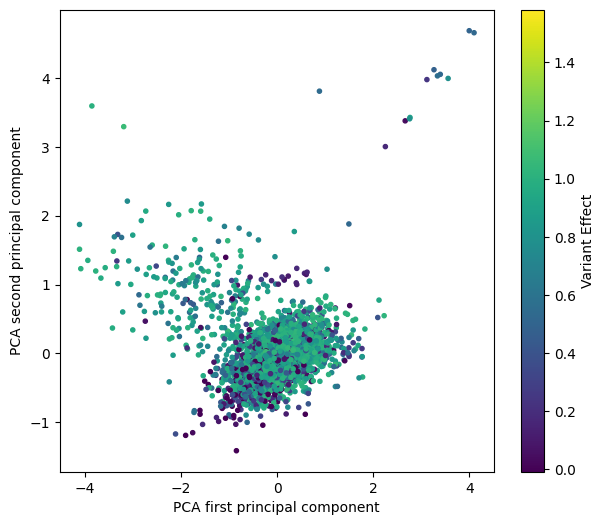

In [4]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$



Since $\epsilon\sim N(0, \sigma^2)$, 

$$E[\epsilon]=0$$
$$E[\epsilon^2]=E^2[\epsilon]+Var[\epsilon]=\sigma^2$$

$\begin{aligned} \mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right]   &= \mathbb{E}_{D} \left[y^2-2y\hat{f}(x)+\hat{f}(x)^2\right] \\ &= \mathbb{E}_{D} \left[ (f(x)+\epsilon)^2\right] -2\mathbb{E}_{D} \left[ (f(x)+\epsilon)\hat{f}(x)\right] + \mathbb{E}_{D} \left[ \hat{f}(x)^2\right] \\ &= \mathbb{E}_{D} \left[ f(x)^2\right]+\mathbb{E}_{D} \left[ 2\epsilon f(x)\right] +\mathbb{E}_{D} \left[ \epsilon^2\right] -2 \mathbb{E}_{D} \left[ f(x)\hat{f}(x)\right]+\mathbb{E}_{D} \left[ \hat{f}(x)^2\right] \\ &= f(x)^2+\sigma^2-2f(x)\mathbb{E}_{D} \left[ \hat{f}(x)\right]+\mathbb{E}_{D} \left[ \hat{f}(x)^2 \right] \\ &= \left( \mathbb{E} \left[ \hat{f}(x) \right] -f(x)\right)^2 + \left( \mathbb{E}_{D} \left[ \hat{f}(x)^2 \right] - \mathbb{E}^{2}_{D}  \left[ \hat{f}(x) \right]\right) +\sigma^2  \\ &= \left( \mathbb{E} \left[ \hat{f}(x) \right] -f(x)\right)^2 + \text{Var} \left[ \hat{f}(x) \right]+\sigma^2 \\ &= \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{\text{Bias}^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{\text{Variance}} + \underbrace{\sigma^2}_{\text{Irreducible Error}} \end{aligned}$



#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?

Answer:

A model has high bias when its predictions $\hat{f}(x)$ are systematically different from the true values $y$, meaning it makes consistent errors regardless of the training dataset. This often results in underfitting, where the model is too simple to capture the underlying patterns in the data. Over-simplified model assumptions, too strong regularization and inaccurate feature selections are potential causes of high bias.

#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

Answer:

A model has high variance when it is overly sensitive to small fluctuations in the training data, leading to inconsistent predictions on different datasets. This typically results in overfitting, where the model captures noise rather than true underlying patterns. Over-complex model, weak(or no) regularization and small training dataset are potential causes of high variance.

#### [5 Points] 1.4 Can bias and variance decrease at the same time?

Answer:

In general, bias and variance trade off—reducing one often increases the other. However, in some cases, both bias and variance can decrease together, such as: 
- better model selection
- proper regularization
- increasing training data
-  feature engineering

# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$

Answer:

$$L = (\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta =\beta^T\textbf{X}^T\textbf{X}\beta+\textbf{y}^T\textbf{y}-\textbf{y}^T\textbf{X}\beta-\beta^T\textbf{X}^T\textbf{y}+\lambda\beta^T\beta$$

$$\frac{\partial L}{\partial\beta}=2\textbf{X}^T\textbf{X}\beta-2\textbf{X}^T\textbf{y}+2\lambda\beta=0$$

$$(\textbf{X}^T\textbf{X}+\lambda \textbf{I})\beta=\textbf{X}^T\textbf{y}$$

$$\hat{\beta}=(\textbf{X}^T\textbf{X}+\lambda \textbf{I})^{-1}\textbf{X}^T\textbf{y}$$

#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?
As we increase the lambda parameter:

- MSE initially decreases because regularization helps reduce overfitting.

- MSE starts increasing at higher lambda values because excessive regularization causes underfitting.
- Variance decreases as lambda increases since the model becomes more constrained and less sensitive to fluctuations in the data. This demonstrates the tradeoff between bias and variance in ridge regression.


In [5]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # Closed-form solution
        self.beta = np.linalg.solve(XTX + self.lambda_reg * I, XTy)

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        return np.mean((y_true - y_pred) ** 2)

In [6]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

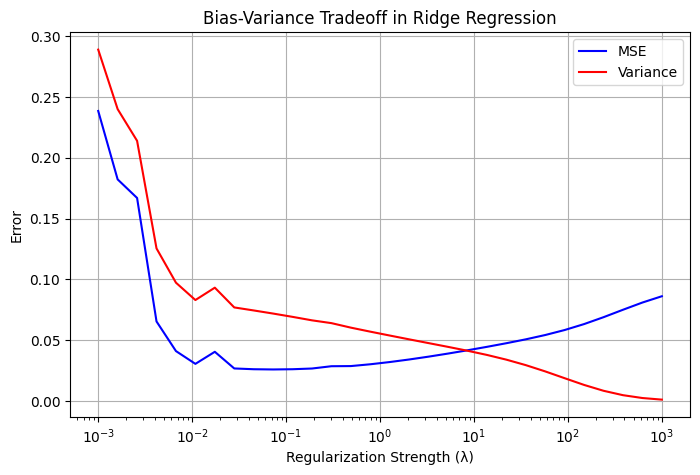

In [7]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

Answer: The parameter **$\gamma$** acts as a binary selection variable for each regression coefficient $\beta_j$.

- When **$\gamma_j = 1$**:
  - The coefficient $\beta_j$ which follows a normal prior: $\beta_j \sim N(0, \sigma_\beta^2)$ is included in the model.
- When **$\gamma_j = 0$**:
  - The coefficient $\beta_j$ is set to zero and excluded from the model.

Thus, $\gamma$ acts as a feature selection mechanism, enforcing sparsity in $\beta$. This setup is a Bayesian variable selection method, where features with a high posterior probability of $\gamma_j = 1$ are considered important.

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

Answer:

Since $$\textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2) \text{ , }\quad \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , }\quad \gamma_j \sim \text{Bernoulli}(p)$$

We got,

$$p(\mathbf{y} | \mathbf{X}, \gamma, \beta) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(y_i - (\gamma \circ \beta)^T \mathbf{x}_i)^2}{2\sigma^2} \right)$$

$$p(\beta | \gamma) = \prod_{j=1}^{d} \left( \frac{1}{\sqrt{2\pi\sigma_{\beta}^2}}\exp\left( - \frac{\beta_j^2}{2\sigma_{\beta}^2}\right)\right)^{\gamma_j}$$

$$p(\gamma) = \prod_{j=1}^{d} p^{\gamma_j} (1 - p)^{1 - \gamma_j}$$


Since $\sigma$ is fixed, we got the final posterior expression:

$$ p(\gamma, \beta | \mathbf{X}, \mathbf{y}) \propto p( \mathbf{y}| \mathbf{X}, \gamma, \beta) p(\beta|\gamma) p(\gamma) $$

$$ p(\gamma, \beta | \mathbf{X}, \mathbf{y}) \propto \left[ \prod_{i=1}^{n} \exp\left( -\frac{(y_i - (\gamma \circ \beta)^T \mathbf{x}_i)^2}{2\sigma^2} \right) \right]\times \left[ \prod_{j=1}^{d} \left( \frac{1}{\sqrt{2\pi\sigma_{\beta}^2}}\exp\left( - \frac{\beta_j^2}{2\sigma_{\beta}^2}\right)\right)^{\gamma_j}\right] \times \left[ \prod_{j=1}^{d} p^{\gamma_j} (1 - p)^{1 - \gamma_j} \right] $$

$$\log p(\gamma, \beta | \mathbf{X}, \mathbf{y}) = -\sum_{i=1}^{n} \frac{(y_i - (\gamma \circ \beta)^T \mathbf{x}_i)^2}{2\sigma^2}- \sum_{j=1}^{d}\frac{\gamma_j}{2}\log(\sigma_{\beta}^2) - \sum_{j=1}^{d} \frac{\gamma_j}{2\sigma_\beta^2} \beta_j^2 + \sum_{j=1}^{d} \left( \gamma_j \log p + (1 - \gamma_j) \log (1 - p) \right)+ C$$
#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

Answer:

The bar plot shows the MAP estimate of each $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$, which represents the most probable values of the feature $\beta_j$ inclusion probabilities given the data. Red dash line is $p=0.5$, which is the average inclusion probability in the prior.

- if $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ is high(>0.5), it means that the feature $j$ is highly likely to be included in the model and it's more important features
- if $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ is low(<0.5), it means that the feature $j$ is less likely to be included in the model and it's less important(more irrelevant) features

In [13]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()

gamma_map = map_estimate["gamma"]


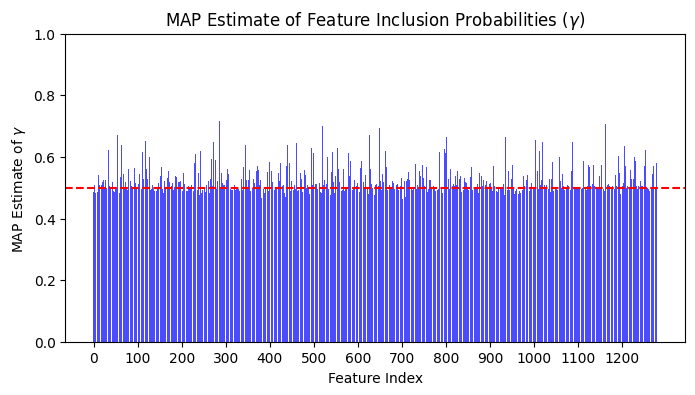

In [15]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of $\gamma$")
plt.title("MAP Estimate of Feature Inclusion Probabilities ($\gamma$)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
# add 0.5 threshold
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

# [10 Points] Question 3: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Define Ridge Regression model
ridge_model = Ridge()

# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': np.logspace(-3, 3, 30)}  # 30 values from 0.001 to 1000

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(ridge_model, param_grid, cv=3)


grid_search.fit(Xs_train, ys_train)



/Users/hy2897/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.09619e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/hy2897/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.57099e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/hy2897/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.26943e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/hy2897/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.54283e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/hy2897/Li

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])})

In [23]:
# Retrieve the best alpha parameter
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Evaluate on the testing data
y_pred = grid_search.best_estimator_.predict(Xs_test)
mse = mean_squared_error(ys_test, y_pred)
print(f"Mean Squared Error on test set: {mse}")

Best alpha: 0.11721022975334805
Mean Squared Error on test set: 0.025912761761867128
